In [1]:
!python --version

Python 3.9.7


In [2]:
rm -rf /home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy-1.22.2.dist-info/

In [3]:
!pip install SQLAlchemy

In [4]:
!pip install py4j==0.10.9.3

In [5]:
!pip install pypmml==0.9.12

In [6]:
%pip install snowflake-connector-python[pandas]


Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install --upgrade shap-hypetune


Note: you may need to restart the kernel to use updated packages.


In [11]:
# import basic data science libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import snowflake.connector

In [12]:
eval_metric_k_cards = 100

In [13]:
import getpass

# using a simpler way to use your login info without embedding it in the notebook 
# other enterprise connection patterns (e.g., SSO) are in the Snowflake docs: https://docs.snowflake.com/en/user-guide/python-connector-example.html
snowflake_username = getpass.getpass("Enter Snowflake Username")
snowflake_pwd = getpass.getpass("Enter Snowflake Password")
snowflake_acct = 'nna57244.us-east-1'

#print(snowflake_username)
#print(snowflake_acct)

Enter Snowflake Username ··········
Enter Snowflake Password ·········


In [14]:

# Gets the version
ctx = snowflake.connector.connect(
  user=snowflake_username,
  password=snowflake_pwd,
  account=snowflake_acct
  )
cs = ctx.cursor()
try:
    cs.execute("SELECT current_version()")
    one_row = cs.fetchone()
    print(one_row[0])

    cs.execute("USE DATABASE CREDIT_CARD_COMPANY_DB;")    

    all_rows = cs.execute("select * FROM CUSTOMER_CC_TRANSACTION_FEATURES;")
    df_cc_customer_txn_features = all_rows.fetch_pandas_all()

finally:
    cs.close()



ctx.close()

6.13.1


In [15]:

df_cc_customer_txn_features

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUST_CNT_TX_1,CUST_AVG_AMOUNT_1,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30
0,504160,1619,8499,2018-05-23 12:08:44,185.09,4536524,52,0,0,0,0,9,625.338889,25,1755.396800,112,9805.304286
1,504188,4816,1722,2018-05-23 12:11:18,50.97,4536678,52,0,0,0,0,1,50.970000,11,477.563636,55,2656.496727
2,504344,3463,1879,2018-05-23 12:24:06,50.26,4537446,52,0,0,0,0,1,50.260000,13,674.776154,68,3970.189118
3,504363,4486,6513,2018-05-23 12:25:25,39.58,4537525,52,0,0,0,0,3,51.893333,14,270.737143,59,1153.980847
4,504393,3784,1980,2018-05-23 12:28:42,52.02,4537722,52,0,0,0,0,3,143.410000,21,1287.217143,90,5929.218000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12283,963897,3979,8849,2018-07-10 11:53:23,18.68,8682803,100,0,0,0,0,2,68.170000,21,922.609524,84,3359.152381
12284,963945,1111,967,2018-07-10 11:57:48,36.72,8683068,100,0,0,0,0,4,38.480000,30,880.656000,107,3271.224673
12285,963961,3828,2735,2018-07-10 11:59:20,5.91,8683160,100,0,0,0,0,2,7.085000,2,7.085000,9,41.794444
12286,963981,3927,2053,2018-07-10 12:00:37,24.65,8683237,100,0,0,0,0,4,136.637500,14,837.862143,65,5018.625846


## Create the Terminal Features

* Let us perform the computation of the risk scores by defining a get_count_risk_rolling_window function. 
* The function takes as inputs 
   * the DataFrame of transactions for a given terminal ID, 
   * the delay period, 
      * Contrary to customer ID transformations, the time windows will not directly precede a given transaction. Instead, they will be shifted back by a delay period. The delay period accounts for the fact that, in practice, the fraudulent transactions are only discovered after a fraud investigation or a customer complaint. Hence, the fraudulent labels, which are needed to compute the risk score, are only available after this delay period. To a first approximation, this delay period will be set to one week. The motivations for the delay period will be further argued in Chapter 5, Validation strategies.
   * and a list of window sizes. 
* In the first stage, the number of transactions and fraudulent transactions are computed for the delay period:
   * NB_TX_DELAY
   * NB_FRAUD_DELAY
* In the second stage, the number of transactions and fraudulent transactions are computed for each window size plus the delay period (NB_TX_DELAY_WINDOW and NB_FRAUD_DELAY_WINDOW). 
* The number of transactions and fraudulent transactions that occurred for a given window size, shifted back by the delay period, is then obtained by simply computing 
   * the differences of the quantities obtained for the delay period, 
   * and the window size plus delay period:
      * NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
      * NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
* The risk score is finally obtained by computing the proportion of fraudulent transactions for each window size (or 0 if no transaction occurred for the given window):

RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW


In [16]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

In [17]:
df_cc_customer_txn_features[df_cc_customer_txn_features.TX_FRAUD==0].TERMINAL_ID[0]


0    8499
0    6270
0    5409
0    1463
0    4427
0     687
0    7066
0    8508
0    4732
0     249
0    3760
0    5118
0    6769
0    2571
0    3503
0    8636
0    7725
0    8865
0    7817
0     199
0    5450
0     130
0    7082
0    2996
0    3459
0    4734
0    6415
0    9262
0    4996
0     849
0    3917
0    8276
0    4301
Name: TERMINAL_ID, dtype: int16

In [18]:
get_count_risk_rolling_window(df_cc_customer_txn_features[df_cc_customer_txn_features.TERMINAL_ID==3059], delay_period=7, windows_size_in_days=[1,7,30])


,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,,
3527,3527,3774,3059,2018-04-01 10:17:43,225.41,37063,0,1,1,1,...,3,158.073333,3,158.073333,0.0,0.0,0.0,0.0,0.0,0.0
4732,4732,55,3059,2018-04-01 11:59:14,36.28,43154,0,0,0,1,...,2,35.670000,2,35.670000,0.0,0.0,0.0,0.0,0.0,0.0
16216,16216,4879,3059,2018-04-02 14:47:34,105.00,139654,1,0,0,0,...,10,415.229000,10,415.229000,0.0,0.0,0.0,0.0,0.0,0.0
18249,18249,2263,3059,2018-04-02 19:08:10,90.89,155290,1,0,0,0,...,7,198.907143,7,198.907143,0.0,0.0,0.0,0.0,0.0,0.0
26512,26512,4879,3059,2018-04-03 15:44:49,58.51,229489,2,0,0,0,...,14,844.365714,14,844.365714,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697944,1697944,402,3059,2018-09-25 05:32:56,57.30,15312776,177,0,0,0,...,1,57.300000,1,57.300000,1.0,0.0,9.0,0.0,36.0,0.0
1701971,1701971,1035,3059,2018-09-25 12:30:54,7.56,15337854,177,0,0,0,...,4,8.465000,4,8.465000,2.0,0.0,10.0,0.0,36.0,0.0
1704512,1704512,1519,3059,2018-09-25 16:37:41,35.79,15352661,177,0,0,0,...,3,32.196667,3,32.196667,1.0,0.0,9.0,0.0,36.0,0.0


In [19]:
%time df_cc_customer_txn_features=df_cc_customer_txn_features.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
df_cc_customer_txn_features=df_cc_customer_txn_features.sort_values('TX_DATETIME').reset_index(drop=True)

CPU times: user 1min 30s, sys: 518 ms, total: 1min 31s
Wall time: 1min 31s


In [20]:
df_cc_customer_txn_features

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,596,3156,2018-04-01 00:00:31,57.16,31,0,0,0,1,...,1,57.160000,1,57.160000,0.0,0.0,0.0,0.0,0.0,0.00000
1,1,4961,3412,2018-04-01 00:02:10,81.51,130,0,0,0,1,...,1,81.510000,1,81.510000,0.0,0.0,0.0,0.0,0.0,0.00000
2,2,2,1365,2018-04-01 00:07:56,146.00,476,0,0,0,1,...,1,146.000000,1,146.000000,0.0,0.0,0.0,0.0,0.0,0.00000
3,3,4128,8737,2018-04-01 00:09:29,64.49,569,0,0,0,1,...,1,64.490000,1,64.490000,0.0,0.0,0.0,0.0,0.0,0.00000
4,4,927,9906,2018-04-01 00:10:34,50.99,634,0,0,0,1,...,1,50.990000,1,50.990000,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,161,655,2018-09-30 23:56:36,54.24,15810996,182,0,0,1,...,2,75.280000,2,75.280000,1.0,0.0,4.0,0.0,28.0,0.00000
1754151,1754151,4342,6181,2018-09-30 23:57:38,1.23,15811058,182,0,0,1,...,1,1.230000,1,1.230000,1.0,0.0,9.0,0.0,39.0,0.00000
1754152,1754152,618,1502,2018-09-30 23:58:21,6.62,15811101,182,0,0,1,...,5,7.368000,5,7.368000,1.0,0.0,5.0,0.0,33.0,0.00000
1754153,1754153,4056,3067,2018-09-30 23:59:52,55.40,15811192,182,0,0,1,...,3,100.696667,3,100.696667,1.0,0.0,6.0,0.0,28.0,0.00000


In [21]:
# save a copy of the processed features to use with the streamlit application in part 5
df_cc_customer_txn_features.to_csv("cc_fraud_processed_features.csv")

# Modeling Work


In [22]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be compromised after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known defrauded customers from the training set
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Compromised cards from that test day, minus the delay period, are added to the pool of known defrauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [23]:
%pip install sklearn
import sklearn

Note: you may need to restart the kernel to use updated packages.


In [24]:
%pip install graphviz
import graphviz

Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [26]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [27]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [28]:
# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   435k      0 --:--:-- --:--:-- --:--:--  435k


In [29]:
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

In [30]:
df_cc_customer_txn_features

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,596,3156,2018-04-01 00:00:31,57.16,31,0,0,0,1,...,1,57.160000,1,57.160000,0.0,0.0,0.0,0.0,0.0,0.00000
1,1,4961,3412,2018-04-01 00:02:10,81.51,130,0,0,0,1,...,1,81.510000,1,81.510000,0.0,0.0,0.0,0.0,0.0,0.00000
2,2,2,1365,2018-04-01 00:07:56,146.00,476,0,0,0,1,...,1,146.000000,1,146.000000,0.0,0.0,0.0,0.0,0.0,0.00000
3,3,4128,8737,2018-04-01 00:09:29,64.49,569,0,0,0,1,...,1,64.490000,1,64.490000,0.0,0.0,0.0,0.0,0.0,0.00000
4,4,927,9906,2018-04-01 00:10:34,50.99,634,0,0,0,1,...,1,50.990000,1,50.990000,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,161,655,2018-09-30 23:56:36,54.24,15810996,182,0,0,1,...,2,75.280000,2,75.280000,1.0,0.0,4.0,0.0,28.0,0.00000
1754151,1754151,4342,6181,2018-09-30 23:57:38,1.23,15811058,182,0,0,1,...,1,1.230000,1,1.230000,1.0,0.0,9.0,0.0,39.0,0.00000
1754152,1754152,618,1502,2018-09-30 23:58:21,6.62,15811101,182,0,0,1,...,5,7.368000,5,7.368000,1.0,0.0,5.0,0.0,33.0,0.00000
1754153,1754153,4056,3067,2018-09-30 23:59:52,55.40,15811192,182,0,0,1,...,3,100.696667,3,100.696667,1.0,0.0,6.0,0.0,28.0,0.00000


In [31]:
(train_df, test_df)=get_train_test_set(df_cc_customer_txn_features,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

test_df_copy_validate = test_df.copy()

In [32]:
train_df.shape


(67240, 23)

In [33]:
df_cc_customer_txn_features[ (df_cc_customer_txn_features["CUSTOMER_ID"] == 1111) & (df_cc_customer_txn_features["TERMINAL_ID"] == 2328) ]

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
168639,168640,1111,2328,2018-04-18 13:13:18,31.58,1516398,17,0,0,0,...,35,961.929143,60,1698.962000,0.0,0.0,6.0,0.000000,9.0,0.000000
204931,204932,1111,2328,2018-04-22 10:25:09,62.96,1851909,21,0,0,1,...,32,973.497500,76,2214.058421,1.0,0.0,8.0,0.000000,14.0,0.000000
212540,212540,1111,2328,2018-04-23 06:36:41,27.94,1924601,22,0,0,0,...,35,1064.578286,82,2414.470732,1.0,0.0,8.0,0.000000,15.0,0.000000
286461,286461,1111,2328,2018-04-30 17:15:55,42.51,2567755,29,0,0,0,...,29,966.125862,110,3379.176455,3.0,0.0,14.0,0.000000,30.0,0.000000
401594,401594,1111,2328,2018-05-12 17:07:35,40.92,3604055,41,0,0,1,...,25,845.419600,126,3949.379921,0.0,0.0,5.0,0.000000,38.0,0.000000
456223,456223,1111,2328,2018-05-18 12:14:30,18.55,4104870,47,0,0,0,...,30,890.008333,115,3765.241304,1.0,0.0,7.0,0.000000,41.0,0.000000
494584,494584,1111,2328,2018-05-22 11:51:52,43.01,4449112,51,0,0,0,...,34,890.405000,119,3815.361429,2.0,0.0,9.0,0.000000,41.0,0.000000
705966,705966,1111,2328,2018-06-13 13:27:59,28.47,6355679,73,0,0,0,...,26,747.042308,111,3375.993694,1.0,0.0,7.0,0.000000,31.0,0.000000
725577,725577,1111,2328,2018-06-15 14:15:18,4.58,6531318,75,0,0,0,...,25,796.313200,111,3473.371261,5.0,0.0,10.0,0.000000,34.0,0.000000
792226,792226,1111,2328,2018-06-22 13:36:49,59.58,7133809,82,0,0,0,...,27,769.278148,103,3201.500000,1.0,0.0,14.0,0.000000,39.0,0.000000


In [34]:
train_df[ (train_df["CUSTOMER_ID"] == 1111) & (train_df["TERMINAL_ID"] == 2328) ]

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1102483,1102483,1111,2328,2018-07-25 00:00:29,40.77,9936029,115,0,0,0,...,24,661.51875,105,3124.508286,1.0,0.0,10.0,0.0,32.0,0.0


In [35]:
train_df[train_df.TX_FRAUD==1].shape


(598, 23)

In [36]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 
                'CUST_CNT_TX_1',
                'CUST_AVG_AMOUNT_1', 
                'CUST_CNT_TX_7',
                'CUST_AVG_AMOUNT_7', 
                'CUST_CNT_TX_30',
                'CUST_AVG_AMOUNT_30',
                'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
               'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
               'TERMINAL_ID_RISK_30DAY_WINDOW'                
               ]

In [37]:
import sklearn_pandas
from sklearn_pandas import DataFrameMapper

In [38]:
# we use this feature transform pipeline to save with our PMML model later on at the end of this notebook
# we will use the pipeline over in the streamlit application

x_train_mapper = DataFrameMapper([
    
  (['TX_AMOUNT'], sklearn.preprocessing.StandardScaler()),
  (['TX_DURING_WEEKEND'], sklearn.preprocessing.StandardScaler()),
  (['TX_DURING_NIGHT'], sklearn.preprocessing.StandardScaler()),
  (['CUST_CNT_TX_1'], sklearn.preprocessing.StandardScaler()),
  (['CUST_AVG_AMOUNT_1'], sklearn.preprocessing.StandardScaler()),
    (['CUST_CNT_TX_7'], sklearn.preprocessing.StandardScaler()),
    (['CUST_AVG_AMOUNT_7'], sklearn.preprocessing.StandardScaler()),
    (['CUST_CNT_TX_30'], sklearn.preprocessing.StandardScaler()),
    (['CUST_AVG_AMOUNT_30'], sklearn.preprocessing.StandardScaler()),
    (['TERMINAL_ID_RISK_1DAY_WINDOW'], sklearn.preprocessing.StandardScaler()),
    (['TERMINAL_ID_NB_TX_7DAY_WINDOW'], sklearn.preprocessing.StandardScaler()),
    (['TERMINAL_ID_RISK_7DAY_WINDOW'], sklearn.preprocessing.StandardScaler()),
    (['TERMINAL_ID_NB_TX_30DAY_WINDOW'], sklearn.preprocessing.StandardScaler()),
    (['TERMINAL_ID_RISK_30DAY_WINDOW'], sklearn.preprocessing.StandardScaler())
    
  ], df_out=True)



def scaleDataFrameMapper(train,test,features):
    x_train_mapper.fit( train[features] )
    
    train_new = train.copy()
    test_new = test.copy()

    train_new[features] = x_train_mapper.transform(train[features])
    test_new[features] = x_train_mapper.transform(test[features])
    
    return (train_new,test_new)

In [39]:
def fit_model_and_get_predictions(classifier, input_train_df, input_test_df, 
                                  input_features, output_feature="TX_FRAUD",scale=True):

    # By default, scales input data
    if scale:
        (train_df, test_df) = scaleDataFrameMapper(input_train_df, input_test_df, input_features)
    else:
        train_df = input_train_df
        test_df = input_test_df
        
            
    
    # We first train the classifier using the `fit` method, and pass as arguments the input and output features
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # We then get the predictions on the training and test data using the `predict_proba` method
    # The predictions are returned as a numpy array, that provides the probability of fraud for each transaction 
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # The result is returned as a dictionary containing the fitted models, 
    # and the predictions on the training and test sets
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

In [40]:
# We first create a decision tree object. We will limit its depth to 2 for interpretability, 
# and set the random state to zero for reproducibility
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=False)

In [41]:
test_df['TX_FRAUD_PREDICTED']=model_and_predictions_dictionary['predictions_test']
test_df.head()

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
1236698,1236698,2765,2747,2018-08-08 00:01:14,42.32,11145674,129,0,0,0,...,42.32,1,42.32,2.0,0.0,9.0,0.0,31.0,0.000000,0.003536
1236699,1236699,714,2073,2018-08-08 00:02:33,108.19,11145753,129,0,0,0,...,108.19,1,108.19,2.0,0.0,10.0,0.0,23.0,0.000000,0.003536
1236701,1236701,4982,1258,2018-08-08 00:08:40,26.13,11146120,129,0,0,0,...,26.13,1,26.13,1.0,0.0,10.0,0.0,26.0,0.076923,0.003536
1236702,1236702,704,8501,2018-08-08 00:08:41,65.81,11146121,129,0,0,0,...,65.81,1,65.81,1.0,0.0,6.0,0.0,23.0,0.000000,0.003536
1236703,1236703,3085,4208,2018-08-08 00:10:34,55.22,11146234,129,0,0,0,...,55.22,1,55.22,1.0,0.0,5.0,0.0,21.0,0.523810,0.003536


In [42]:
def card_precision_top_k_day(df_day,top_k):
    
    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID, 
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k
    
    return list_detected_compromised_cards, card_precision_top_k

def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # At first, the list of detected compromised cards is empty
    list_detected_compromised_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []
    
    # For each day, compute precision top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Let us remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]
        
        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        # Let us update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)
        
    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

In [43]:
predictions_df=test_df
predictions_df['predictions']=0.5
    
rand_assess = performance_assessment(predictions_df, top_k_list=[eval_metric_k_cards])
rand_assess

,AUC ROC,Average precision,Card Precision@100
0,0.5,0.007,0.017


In [44]:
print(rand_assess.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>AUC ROC</th>
      <th>Average precision</th>
      <th>Card Precision@100</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.5</td>
      <td>0.007</td>
      <td>0.017</td>
    </tr>
  </tbody>
</table>


In [45]:

predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
    
dt_assessment = performance_assessment(predictions_df, top_k_list=[eval_metric_k_cards])
dt_assessment

,AUC ROC,Average precision,Card Precision@100
0,0.763,0.496,0.241


In [46]:
print(dt_assessment.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>AUC ROC</th>
      <th>Average precision</th>
      <th>Card Precision@100</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.763</td>
      <td>0.496</td>
      <td>0.241</td>
    </tr>
  </tbody>
</table>


In [47]:
train_df

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1102483,1102483,1111,2328,2018-07-25 00:00:29,40.77,9936029,115,0,0,0,...,24,661.518750,105,3124.508286,1.0,0.0,10.0,0.0,32.0,0.000000
1102484,1102484,676,6846,2018-07-25 00:01:08,9.62,9936068,115,0,0,0,...,15,278.291333,61,1104.007705,2.0,0.0,5.0,0.0,27.0,0.000000
1102485,1102485,402,4771,2018-07-25 00:01:35,81.55,9936095,115,0,0,0,...,11,1948.493636,50,5520.171000,0.0,0.0,12.0,0.0,37.0,0.000000
1102486,1102486,4218,863,2018-07-25 00:01:43,23.10,9936103,115,0,0,0,...,24,486.702500,93,1836.018387,2.0,0.0,6.0,0.0,22.0,0.000000
1102487,1102487,3711,3599,2018-07-25 00:02:26,59.25,9936146,115,0,0,0,...,27,2114.484444,110,8098.718636,1.0,0.0,10.0,0.0,38.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169718,1169718,4219,557,2018-07-31 23:55:06,60.66,10540506,121,0,0,0,...,27,716.027037,109,3579.999174,0.0,0.0,13.0,0.0,52.0,0.000000
1169719,1169719,1044,4831,2018-07-31 23:56:10,47.20,10540570,121,0,0,0,...,34,1028.906176,126,3930.300079,1.0,0.0,8.0,0.0,33.0,0.030303
1169720,1169720,1182,9765,2018-07-31 23:57:42,47.74,10540662,121,0,0,0,...,17,463.796471,80,2672.150375,2.0,0.0,6.0,0.0,19.0,0.000000
1169721,1169721,3802,2777,2018-07-31 23:58:14,22.26,10540694,121,0,0,0,...,5,35.332000,37,553.121622,3.0,0.0,7.0,0.0,20.0,0.000000


In [48]:
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                        'HistGradientBoostingClassifier': sklearn.ensemble.HistGradientBoostingClassifier()
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                                                  input_features=input_features,
                                                                                output_feature=output_feature)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions


[15:07:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [49]:
train_df

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1102483,1102483,1111,2328,2018-07-25 00:00:29,40.77,9936029,115,0,0,0,...,24,661.518750,105,3124.508286,1.0,0.0,10.0,0.0,32.0,0.000000
1102484,1102484,676,6846,2018-07-25 00:01:08,9.62,9936068,115,0,0,0,...,15,278.291333,61,1104.007705,2.0,0.0,5.0,0.0,27.0,0.000000
1102485,1102485,402,4771,2018-07-25 00:01:35,81.55,9936095,115,0,0,0,...,11,1948.493636,50,5520.171000,0.0,0.0,12.0,0.0,37.0,0.000000
1102486,1102486,4218,863,2018-07-25 00:01:43,23.10,9936103,115,0,0,0,...,24,486.702500,93,1836.018387,2.0,0.0,6.0,0.0,22.0,0.000000
1102487,1102487,3711,3599,2018-07-25 00:02:26,59.25,9936146,115,0,0,0,...,27,2114.484444,110,8098.718636,1.0,0.0,10.0,0.0,38.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169718,1169718,4219,557,2018-07-31 23:55:06,60.66,10540506,121,0,0,0,...,27,716.027037,109,3579.999174,0.0,0.0,13.0,0.0,52.0,0.000000
1169719,1169719,1044,4831,2018-07-31 23:56:10,47.20,10540570,121,0,0,0,...,34,1028.906176,126,3930.300079,1.0,0.0,8.0,0.0,33.0,0.030303
1169720,1169720,1182,9765,2018-07-31 23:57:42,47.74,10540662,121,0,0,0,...,17,463.796471,80,2672.150375,2.0,0.0,6.0,0.0,19.0,0.000000
1169721,1169721,3802,2777,2018-07-31 23:58:14,22.26,10540694,121,0,0,0,...,5,35.332000,37,553.121622,3.0,0.0,7.0,0.0,20.0,0.000000


In [50]:
def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test',
                                            top_k_list=[100]):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]
        
        performances=performances.append(performances_model)
        
    return performances

In [51]:
# performances on test set
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test', 
                                                        top_k_list=[eval_metric_k_cards])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.833,0.555,0.271
Decision tree with depth of two,0.763,0.496,0.241
Decision tree - unlimited depth,0.757,0.113,0.204
Random forest,0.835,0.578,0.274
XGBoost,0.830,0.558,0.259
HistGradientBoostingClassifier,0.837,0.519,0.250


In [52]:
print(df_performances.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>AUC ROC</th>
      <th>Average precision</th>
      <th>Card Precision@100</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Logistic regression</th>
      <td>0.833</td>
      <td>0.555</td>
      <td>0.271</td>
    </tr>
    <tr>
      <th>Decision tree with depth of two</th>
      <td>0.763</td>
      <td>0.496</td>
      <td>0.241</td>
    </tr>
    <tr>
      <th>Decision tree - unlimited depth</th>
      <td>0.757</td>
      <td>0.113</td>
      <td>0.204</td>
    </tr>
    <tr>
      <th>Random forest</th>
      <td>0.835</td>
      <td>0.578</td>
      <td>0.274</td>
    </tr>
    <tr>
      <th>XGBoost</th>
      <td>0.830</td>
      <td>0.558</td>
      <td>0.259</td>
    </tr>
    <tr>
      <th>HistGradientBoostingClassifier</th>
      <td>0.837</td>
      <td>0.519</td>
      <td>0.250</td>
    </tr>
  </tbody>
</table>


In [53]:
fitted_models_and_predictions_dictionary

{'Logistic regression': {'classifier': LogisticRegression(random_state=0),
  'predictions_test': array([0.00158981, 0.02075848, 0.00045198, ..., 0.00180617, 0.00055142,
         0.0028888 ]),
  'predictions_train': array([0.00648117, 0.0011145 , 0.01053705, ..., 0.00400311, 0.00288668,
         0.00110461]),
  'training_execution_time': 0.4611966609954834,
  'prediction_execution_time': 0.014113426208496094},
 'Decision tree with depth of two': {'classifier': DecisionTreeClassifier(max_depth=2, random_state=0),
  'predictions_test': array([0.00353643, 0.00353643, 0.00353643, ..., 0.00353643, 0.00353643,
         0.00353643]),
  'predictions_train': array([0.00353643, 0.00353643, 0.00353643, ..., 0.00353643, 0.00353643,
         0.00353643]),
  'training_execution_time': 0.11304616928100586,
  'prediction_execution_time': 0.011443376541137695},
 'Decision tree - unlimited depth': {'classifier': DecisionTreeClassifier(random_state=0),
  'predictions_test': array([0., 0., 1., ..., 0., 0.,

In [54]:
from scipy import stats
from hyperopt import hp

param_grid = {
    'learning_rate': [0.3, 0.2, 0.1],
    'num_leaves': [25, 30, 35, 40],
    'max_depth': [4, 10],
    'gamma': [1, 3, 5, 7],
    'min_child_weight': [1, 3, 5, 7]
    
}

param_dist = {
    'learning_rate': stats.uniform(0.09, 0.25),
    'num_leaves': stats.randint(20,40),
    'max_depth': [10, 12]
}

param_dist_hyperopt = {
    'max_depth': 15 + hp.randint('num_leaves', 10), 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}


#regr_xgb = XGBRegressor(n_estimators=150, random_state=0, verbosity=0, n_jobs=-1)
xgb_shap_hyp = xgboost.XGBClassifier(n_estimators=250, random_state=0, verbosity=0, eval_metric="aucpr", n_jobs=-1)

In [55]:
(xgb_train_df, xgb_test_df) = scaleDataFrameMapper(train_df, test_df, input_features)            


In [56]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA
#classifier.fit(train_df[input_features], train_df[output_feature])


#classifier.fit(train_df[input_features], train_df[output_feature])

from sklearn.metrics import roc_auc_score

def AUC(y_true, y_hat):
    return 'auc', roc_auc_score(y_true, y_hat), True


def AP_Score(y_true, y_hat):
    return 'avg_precision', average_precision_score(y_true, y_hat), True

# , eval_metric=AUC
boost_search_model = BoostSearch( xgb_shap_hyp, param_grid=param_grid )
boost_search_model.fit( xgb_train_df[input_features], xgb_train_df[output_feature], eval_set=[(xgb_test_df[input_features], xgb_test_df[output_feature])], early_stopping_rounds=6, eval_metric="aucpr", verbose=0)



384 trials detected for ('learning_rate', 'num_leaves', 'max_depth', 'gamma', 'min_child_weight')

trial: 0001 ### iterations: 00005 ### eval_score: 0.58922
trial: 0002 ### iterations: 00005 ### eval_score: 0.59582
trial: 0003 ### iterations: 00004 ### eval_score: 0.60459
trial: 0004 ### iterations: 00003 ### eval_score: 0.60396
trial: 0005 ### iterations: 00005 ### eval_score: 0.59829
trial: 0006 ### iterations: 00008 ### eval_score: 0.60021
trial: 0007 ### iterations: 00004 ### eval_score: 0.60252
trial: 0008 ### iterations: 00004 ### eval_score: 0.60052
trial: 0009 ### iterations: 00007 ### eval_score: 0.60688
trial: 0010 ### iterations: 00008 ### eval_score: 0.59101
trial: 0011 ### iterations: 00003 ### eval_score: 0.59477
trial: 0012 ### iterations: 00003 ### eval_score: 0.59807
trial: 0013 ### iterations: 00009 ### eval_score: 0.60592
trial: 0014 ### iterations: 00016 ### eval_score: 0.60212
trial: 0015 ### iterations: 00021 ### eval_score: 0.609
trial: 0016 ### iterations: 0000

BoostSearch(estimator=XGBClassifier(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False,
                                    eval_metric='aucpr', gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=250, n_jobs=-1,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=0, reg_alpha=None,
                                    reg_lambda=Non

In [57]:
boost_search_model.estimator_, boost_search_model.best_params_, boost_search_model.best_score_


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='aucpr', gamma=1, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=10, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=250, n_jobs=-1,
               num_leaves=40, num_parallel_tree=1, predictor='auto',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               subsample=1, tree_method='exact', validate_parameters=1,
               verbosity=0),
 {'learning_rate': 0.1,
  'num_leaves': 40,
  'max_depth': 10,
  'gamma': 1,
  'min_child_weight': 1},
 0.583401)

In [58]:
xgb_boost_predictions_test = boost_search_model.estimator_.predict_proba(xgb_test_df[input_features])[:,1]
xgb_boost_predictions_test

array([0.20016964, 0.20016964, 0.20016964, ..., 0.20016964, 0.20016964,
       0.20016964], dtype=float32)

In [59]:
xgb_predictions_df=xgb_test_df
xgb_predictions_df['predictions']=xgb_boost_predictions_test
    
xgb_assessment = performance_assessment(xgb_predictions_df, top_k_list=[eval_metric_k_cards])
xgb_assessment

,AUC ROC,Average precision,Card Precision@100
0,0.809,0.578,0.279


In [60]:
print(xgb_assessment.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>AUC ROC</th>
      <th>Average precision</th>
      <th>Card Precision@100</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.809</td>
      <td>0.578</td>
      <td>0.279</td>
    </tr>
  </tbody>
</table>


# Run GridSearch for Random Forrest


In [61]:
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV


In [62]:
k = 10
cv = StratifiedKFold( n_splits=k)

#RF_params = {'n_estimators':[10,50,100], 'random_state':[42]}

param_grid = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10]}

rf_Classifier = sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1)



In [63]:
rf_model_grid = GridSearchCV(rf_Classifier, param_grid, verbose=2, scoring='average_precision') # 


In [64]:
rf_model_grid.fit(xgb_train_df[input_features], xgb_train_df[output_feature])


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.9s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.1s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.1s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.1s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   1.1s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.1s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.1s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.2s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.1s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   1.1s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   1.1s
[CV] END ..................max_depth=3, min_sampl

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='average_precision', verbose=2)

In [65]:
rf_gs_boost_predictions_test = rf_model_grid.best_estimator_.predict_proba(xgb_test_df[input_features])[:,1]
rf_gs_boost_predictions_test

array([0.00381538, 0.00529458, 0.00540031, ..., 0.00478208, 0.0028208 ,
       0.00362723])

In [66]:
rf_predictions_df=xgb_test_df
rf_predictions_df['predictions']=rf_gs_boost_predictions_test
    
rf_grid_assessment = performance_assessment(rf_predictions_df, top_k_list=[eval_metric_k_cards])
rf_grid_assessment

,AUC ROC,Average precision,Card Precision@100
0,0.838,0.595,0.279


In [67]:
print(rf_grid_assessment.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>AUC ROC</th>
      <th>Average precision</th>
      <th>Card Precision@100</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.838</td>
      <td>0.595</td>
      <td>0.279</td>
    </tr>
  </tbody>
</table>


# Now Run Normal Grid Search for XGBoost


In [68]:
#model_grid = GridSearchCV(model, params, cv=cv, scoring='average_precision') # 
#model_grid.fit(x_train_scaled, y_train_scaled)

xgb_grid_search_model = xgboost.XGBClassifier(n_estimators=250, random_state=0, verbosity=0, eval_metric="aucpr", n_jobs=-1)

In [69]:

k = 10
cv = StratifiedKFold( n_splits=k )
# cv=cv,


param_grid_gscv = {
    'learning_rate': [0.3], # 0.2, 0.1],
    'num_leaves': [25], # 30, 35, 40],
    'max_depth': [4, 10] #, 12, 16, 20]
}

xgb_model_grid = GridSearchCV(xgb_grid_search_model, param_grid, verbose=2, scoring='average_precision') # 


In [70]:
xgb_model_grid.fit(xgb_train_df[input_features], xgb_train_df[output_feature])


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...................max_depth=3, min_samples_split=2; total time=   5.1s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   5.0s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   5.2s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   5.0s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   5.0s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   5.1s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   5.0s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   5.0s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   5.1s
[CV] END ...................max_depth=3, min_samples_split=5; total time=   5.3s
[CV] END ..................max_depth=3, min_samples_split=10; total time=   5.0s
[CV] END ..................max_depth=3, min_sampl

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=250, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                    

In [71]:
xgb_gs_boost_predictions_test = xgb_model_grid.best_estimator_.predict_proba(xgb_test_df[input_features])[:,1]
xgb_gs_boost_predictions_test

array([4.2007014e-05, 6.6414941e-05, 3.9383158e-04, ..., 4.7819424e-04,
       4.0564191e-06, 5.7531153e-05], dtype=float32)

In [72]:
xgb_predictions_df=xgb_test_df
xgb_predictions_df['predictions']=xgb_gs_boost_predictions_test
    
xgb_grid_assessment = performance_assessment(xgb_predictions_df, top_k_list=[eval_metric_k_cards])
xgb_grid_assessment

,AUC ROC,Average precision,Card Precision@100
0,0.831,0.563,0.266


In [73]:
print(xgb_grid_assessment.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>AUC ROC</th>
      <th>Average precision</th>
      <th>Card Precision@100</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.831</td>
      <td>0.563</td>
      <td>0.266</td>
    </tr>
  </tbody>
</table>


# Plot Feature Importance


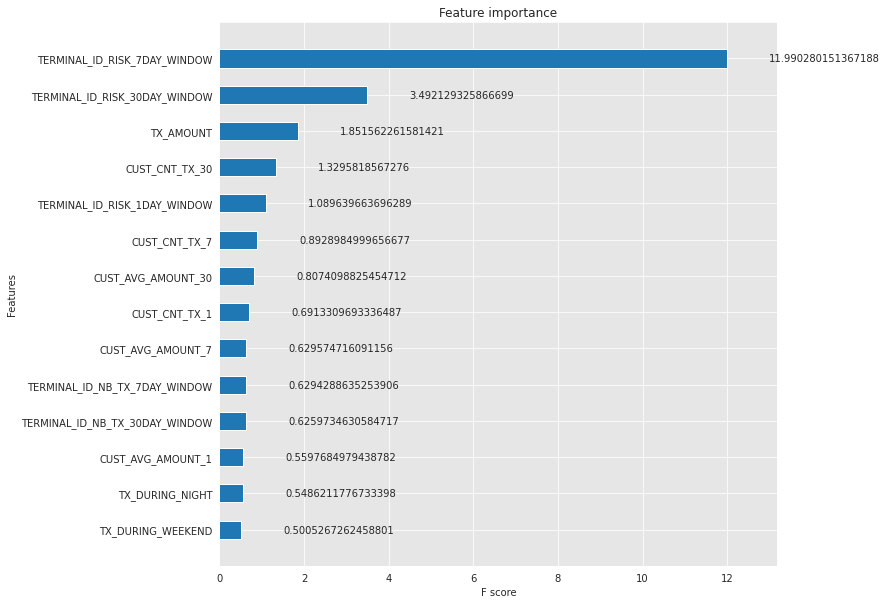

In [74]:
fig, ax = plt.subplots(figsize=(10,10))
xgboost.plot_importance(xgb_model_grid.best_estimator_, max_num_features=50, height=0.5, ax=ax,importance_type='gain')
plt.show()

# Now Analyze SHAP Values

In [75]:
!pip install shap
import shap


## Shap for Random Forrests

In [82]:
best_rf_model = rf_model_grid.best_estimator_

In [83]:
train_data_rf = xgb_train_df[input_features]
train_label_rf = xgb_train_df[output_feature]


In [84]:
#pred = best_rf_model.predict(data, output_margin=True)
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(train_data_rf, approximate=False, check_additivity=False)

#np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

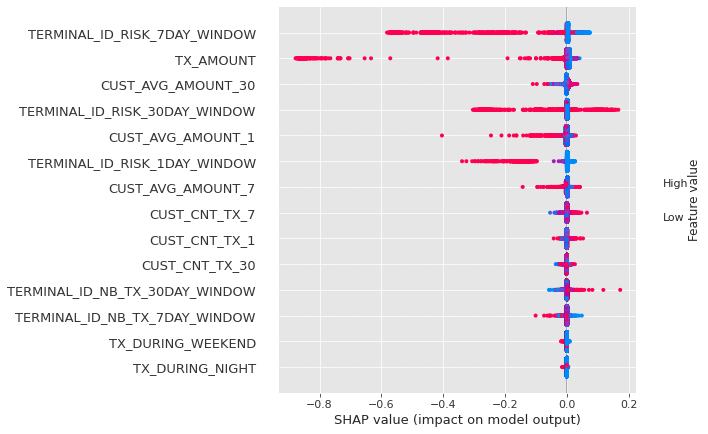

In [86]:
shap.summary_plot(shap_values[0], train_data_rf)


# Now Save the Model as PMML

In [89]:
%pip install sklearn2pmml


Note: you may need to restart the kernel to use updated packages.


In [90]:
import os
java_home = os.environ.get('JAVA_HOME', None)
if not java_home:
    java_path = '/home/studio-lab-user/.conda/envs/studiolab/bin/'
    os.environ['JAVA_HOME'] = java_path
else:
    print(java_home)

In [91]:
!/home/studio-lab-user/.conda/envs/studiolab/bin/java -version

openjdk version "11.0.9.1-internal" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1-internal+0-adhoc..src)
OpenJDK 64-Bit Server VM (build 11.0.9.1-internal+0-adhoc..src, mixed mode)


In [92]:
!/home/studio-lab-user/.conda/envs/default/bin/java -version

/usr/bin/sh: 1: /home/studio-lab-user/.conda/envs/default/bin/java: not found


In [93]:
!java -version

/usr/bin/sh: 1: java: not found


In [94]:
print(os.environ['JAVA_HOME'])

/home/studio-lab-user/.conda/envs/studiolab/bin/


In [95]:
#!jupyter kernelspec list

In [96]:
os.environ["PATH"] += os.pathsep + "/home/studio-lab-user/.conda/envs/studiolab/"

os.environ["PATH"] += os.pathsep + "/home/studio-lab-user/.conda/envs/studiolab/bin/"


In [97]:
!java -version

openjdk version "11.0.9.1-internal" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1-internal+0-adhoc..src)
OpenJDK 64-Bit Server VM (build 11.0.9.1-internal+0-adhoc..src, mixed mode)


In [98]:
test_df_copy_validate[ test_df_copy_validate["TRANSACTION_ID"] == 1236698 ]

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1236698,1236698,2765,2747,2018-08-08 00:01:14,42.32,11145674,129,0,0,0,...,1,42.32,1,42.32,2.0,0.0,9.0,0.0,31.0,0.0


In [99]:
test_df_final = test_df.copy()

test_df_final[input_features] = x_train_mapper.transform(test_df[input_features])




In [100]:
test_df_final

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED,predictions
1236698,1236698,2765,2747,2018-08-08 00:01:14,-0.266899,11145674,129,0,0,-0.62823,...,-2.658733,-1.439136,2.0,-0.075836,0.671790,-0.11808,0.120341,-0.147825,0.003536,0.001281
1236699,1236699,714,2073,2018-08-08 00:02:33,1.295440,11145753,129,0,0,-0.62823,...,-2.658733,-1.415926,2.0,-0.075836,1.005829,-0.11808,-0.847830,-0.147825,0.003536,0.002728
1236701,1236701,4982,1258,2018-08-08 00:08:40,-0.650902,11146120,129,0,0,-0.62823,...,-2.658733,-1.444841,1.0,-0.075836,1.005829,-0.11808,-0.484766,1.128514,0.003536,0.001635
1236702,1236702,704,8501,2018-08-08 00:08:41,0.290249,11146121,129,0,0,-0.62823,...,-2.658733,-1.430859,1.0,-0.075836,-0.330328,-0.11808,-0.847830,-0.147825,0.003536,0.001822
1236703,1236703,3085,4208,2018-08-08 00:10:34,0.039070,11146234,129,0,0,-0.62823,...,-2.658733,-1.434590,1.0,-0.075836,-0.664368,-0.11808,-1.089873,8.543436,0.003536,0.001943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303773,1303773,460,6133,2018-08-14 23:57:03,-0.874093,11750223,135,0,0,-0.62823,...,-2.658733,-1.448157,1.0,-0.075836,-1.332446,-0.11808,-1.210895,-0.147825,0.003536,0.001511
1303775,1303774,3101,3229,2018-08-14 23:58:24,-0.365568,11750304,135,0,0,-0.62823,...,-2.454842,-1.439846,2.0,-0.075836,2.007947,-0.11808,1.451577,-0.147825,0.003536,0.001472
1303774,1303775,4783,7511,2018-08-14 23:58:24,0.386072,11750304,135,0,0,-0.62823,...,-2.590769,-1.421454,0.0,-0.075836,-1.332446,-0.11808,0.483405,-0.147825,0.003536,0.002371
1303776,1303776,2883,8550,2018-08-14 23:58:45,-0.915126,11750325,135,0,0,-0.62823,...,-2.590769,-1.446175,3.0,-0.075836,0.003711,-0.11808,-1.210895,-0.147825,0.003536,0.001356


In [101]:
#df_transform_test[ test_df_copy_validate["TRANSACTION_ID"] == 1236698 ]

In [102]:
test_df[ input_features ]

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUST_CNT_TX_1,CUST_AVG_AMOUNT_1,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1236698,42.32,0,1,1,42.320000,1,42.320000,1,42.320000,0.0,9.0,0.0,31.0,0.000000
1236699,108.19,0,1,1,108.190000,1,108.190000,1,108.190000,0.0,10.0,0.0,23.0,0.000000
1236701,26.13,0,1,1,26.130000,1,26.130000,1,26.130000,0.0,10.0,0.0,26.0,0.076923
1236702,65.81,0,1,1,65.810000,1,65.810000,1,65.810000,0.0,6.0,0.0,23.0,0.000000
1236703,55.22,0,1,1,55.220000,1,55.220000,1,55.220000,0.0,5.0,0.0,21.0,0.523810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303773,16.72,0,0,1,16.720000,1,16.720000,1,16.720000,0.0,3.0,0.0,20.0,0.000000
1303775,38.16,0,0,7,40.305714,7,40.305714,7,40.305714,0.0,13.0,0.0,42.0,0.000000
1303774,69.85,0,0,3,92.500000,3,92.500000,3,92.500000,0.0,3.0,0.0,34.0,0.000000
1303776,14.99,0,0,3,22.343333,3,22.343333,3,22.343333,0.0,7.0,0.0,20.0,0.000000


In [103]:
test_df[ test_df["CUSTOMER_ID"] == 500]

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED,predictions
1248903,1248904,500,7836,2018-08-09 08:26:21,240.15,11262381,130,1,3,0,...,1,240.15,1.0,0.0,5.0,0.0,20.0,0.0,0.984496,0.387571
1254300,1254300,500,9234,2018-08-09 16:40:02,108.41,11292002,130,0,0,0,...,2,174.28,1.0,0.0,6.0,0.0,33.0,0.0,0.003536,0.003056


In [104]:
train_df[ train_df["CUSTOMER_ID"] == 500]

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1102717,1102717,500,6292,2018-07-25 02:12:12,91.36,9943932,115,0,0,0,...,10,468.986000,31,1741.287097,2.0,0.0,7.0,0.0,20.0,0.0
1105530,1105530,500,178,2018-07-25 09:38:20,37.19,9970700,115,0,0,0,...,11,471.536364,32,1742.357188,1.0,0.0,5.0,0.0,28.0,0.0
1113150,1113150,500,6460,2018-07-26 05:39:10,111.21,10042750,116,0,0,0,...,9,480.616667,32,1857.175313,2.0,0.0,6.0,0.0,36.0,0.0
1154214,1154214,500,6436,2018-07-30 10:39:26,66.34,10406366,120,0,0,0,...,4,256.345000,26,1459.241538,2.0,0.0,12.0,0.0,31.0,0.0


In [105]:
df_cc_customer_txn_features[ (df_cc_customer_txn_features["CUSTOMER_ID"] == 500) & (df_cc_customer_txn_features["TX_FRAUD"] == 1) ]

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_DATETIME,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1194268,1194268,500,5761,2018-08-03 12:50:06,211.60,10759806,124,1,3,0,...,2,172.140,23,1342.020,1.0,0.0,5.0,0.0,31.0,0.0
1205588,1205588,500,6750,2018-08-04 15:27:05,122.80,10855625,125,1,3,1,...,5,321.560,25,1485.994,0.0,0.0,5.0,0.0,21.0,0.0
1248903,1248904,500,7836,2018-08-09 08:26:21,240.15,11262381,130,1,3,0,...,1,240.150,1,240.150,1.0,0.0,5.0,0.0,20.0,0.0
1274885,1274885,500,4454,2018-08-11 22:25:11,330.20,11485511,132,1,3,1,...,2,198.645,2,198.645,0.0,0.0,8.0,0.0,28.0,0.0


In [106]:
test_df_copy_validate[ input_features ]

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUST_CNT_TX_1,CUST_AVG_AMOUNT_1,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1236698,42.32,0,1,1,42.320000,1,42.320000,1,42.320000,0.0,9.0,0.0,31.0,0.000000
1236699,108.19,0,1,1,108.190000,1,108.190000,1,108.190000,0.0,10.0,0.0,23.0,0.000000
1236701,26.13,0,1,1,26.130000,1,26.130000,1,26.130000,0.0,10.0,0.0,26.0,0.076923
1236702,65.81,0,1,1,65.810000,1,65.810000,1,65.810000,0.0,6.0,0.0,23.0,0.000000
1236703,55.22,0,1,1,55.220000,1,55.220000,1,55.220000,0.0,5.0,0.0,21.0,0.523810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303773,16.72,0,0,1,16.720000,1,16.720000,1,16.720000,0.0,3.0,0.0,20.0,0.000000
1303775,38.16,0,0,7,40.305714,7,40.305714,7,40.305714,0.0,13.0,0.0,42.0,0.000000
1303774,69.85,0,0,3,92.500000,3,92.500000,3,92.500000,0.0,3.0,0.0,34.0,0.000000
1303776,14.99,0,0,3,22.343333,3,22.343333,3,22.343333,0.0,7.0,0.0,20.0,0.000000


In [107]:
test_df_final[ input_features ]

,TX_AMOUNT,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUST_CNT_TX_1,CUST_AVG_AMOUNT_1,CUST_CNT_TX_7,CUST_AVG_AMOUNT_7,CUST_CNT_TX_30,CUST_AVG_AMOUNT_30,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
1236698,-0.266899,-0.62823,2.181472,-1.522761,-0.834083,-2.334925,-1.297803,-2.658733,-1.439136,-0.075836,0.671790,-0.11808,0.120341,-0.147825
1236699,1.295440,-0.62823,2.181472,-1.522761,-0.386136,-2.334925,-1.205336,-2.658733,-1.415926,-0.075836,1.005829,-0.11808,-0.847830,-0.147825
1236701,-0.650902,-0.62823,2.181472,-1.522761,-0.944182,-2.334925,-1.320530,-2.658733,-1.444841,-0.075836,1.005829,-0.11808,-0.484766,1.128514
1236702,0.290249,-0.62823,2.181472,-1.522761,-0.674340,-2.334925,-1.264828,-2.658733,-1.430859,-0.075836,-0.330328,-0.11808,-0.847830,-0.147825
1236703,0.039070,-0.62823,2.181472,-1.522761,-0.746357,-2.334925,-1.279694,-2.658733,-1.434590,-0.075836,-0.664368,-0.11808,-1.089873,8.543436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303773,-0.874093,-0.62823,-0.458406,-1.522761,-1.008175,-2.334925,-1.333740,-2.658733,-1.448157,-0.075836,-1.332446,-0.11808,-1.210895,-0.147825
1303775,-0.365568,-0.62823,-0.458406,0.850437,-0.847781,-1.606469,-1.300631,-2.454842,-1.439846,-0.075836,2.007947,-0.11808,1.451577,-0.147825
1303774,0.386072,-0.62823,-0.458406,-0.731695,-0.492836,-2.092106,-1.227361,-2.590769,-1.421454,-0.075836,-1.332446,-0.11808,0.483405,-0.147825
1303776,-0.915126,-0.62823,-0.458406,-0.731695,-0.969933,-2.092106,-1.325846,-2.590769,-1.446175,-0.075836,0.003711,-0.11808,-1.210895,-0.147825


In [108]:
classifier = fitted_models_and_predictions_dictionary["XGBoost"]['classifier']

In [109]:
predictions_raw_data = classifier.predict_proba( test_df[ input_features ] )
predictions_raw_data

array([[0.0102846 , 0.9897154 ],
       [0.0102846 , 0.9897154 ],
       [0.0102846 , 0.9897154 ],
       ...,
       [0.01683348, 0.9831665 ],
       [0.01683348, 0.9831665 ],
       [0.01096994, 0.98903006]], dtype=float32)

In [110]:
predictions_transformed_data = classifier.predict_proba( test_df_final[ input_features ] )
predictions_transformed_data

array([[9.9974281e-01, 2.5717140e-04],
       [9.9912822e-01, 8.7177835e-04],
       [9.9845982e-01, 1.5401631e-03],
       ...,
       [9.9583602e-01, 4.1639539e-03],
       [9.9997151e-01, 2.8510734e-05],
       [9.9937904e-01, 6.2093907e-04]], dtype=float32)

In [111]:
p_transformed_features = pd.DataFrame(predictions_transformed_data)
#p.columns = ["prediction"]

In [112]:
p_transformed_features

,0,1
0,0.999743,0.000257
1,0.999128,0.000872
2,0.998460,0.001540
3,0.999807,0.000193
4,0.999248,0.000752
...,...,...
58259,0.999986,0.000014
58260,0.999928,0.000072
58261,0.995836,0.004164
58262,0.999972,0.000029


In [113]:
#predictions_raw_data

p_raw_data = pd.DataFrame(predictions_raw_data)
p_raw_data

,0,1
0,0.010285,0.989715
1,0.010285,0.989715
2,0.010285,0.989715
3,0.010285,0.989715
4,0.005718,0.994282
...,...,...
58259,0.010970,0.989030
58260,0.016833,0.983167
58261,0.016833,0.983167
58262,0.016833,0.983167


In [114]:
results_df = pd.DataFrame({'TRANSACTION_ID': test_df['TRANSACTION_ID'].values,
                           'TX_FRAUD': test_df['TX_FRAUD'].values,
                           'FRAUD_EST_PROB_TRANSFORMED_FEATURES': p_transformed_features.iloc[:, 1].values,
                           'FRAUD_EST_PROB_RAW_DATA': p_raw_data.iloc[:, 1].values
                           #
             })
results_df

,TRANSACTION_ID,TX_FRAUD,FRAUD_EST_PROB_TRANSFORMED_FEATURES,FRAUD_EST_PROB_RAW_DATA
0,1236698,0,0.000257,0.989715
1,1236699,0,0.000872,0.989715
2,1236701,0,0.001540,0.989715
3,1236702,0,0.000193,0.989715
4,1236703,0,0.000752,0.994282
...,...,...,...,...
58259,1303773,0,0.000014,0.989030
58260,1303774,0,0.000072,0.983167
58261,1303775,0,0.004164,0.983167
58262,1303776,0,0.000029,0.983167


In [115]:
results_df[ results_df[ "TX_FRAUD" ] == 1 ]

,TRANSACTION_ID,TX_FRAUD,FRAUD_EST_PROB_TRANSFORMED_FEATURES,FRAUD_EST_PROB_RAW_DATA
12,1236712,1,0.000747,0.989715
104,1236813,1,0.000144,0.989715
445,1237199,1,0.995884,0.989704
997,1237826,1,0.000086,0.989715
1311,1238185,1,0.980445,0.986814
...,...,...,...,...
57105,1302388,1,0.040856,0.982248
57183,1302480,1,0.000222,0.983167
57614,1303006,1,0.111815,0.982248
57922,1303376,1,0.991247,0.986200


In [116]:
results_df[ results_df[ "TX_FRAUD" ] == 0 ]

,TRANSACTION_ID,TX_FRAUD,FRAUD_EST_PROB_TRANSFORMED_FEATURES,FRAUD_EST_PROB_RAW_DATA
0,1236698,0,0.000257,0.989715
1,1236699,0,0.000872,0.989715
2,1236701,0,0.001540,0.989715
3,1236702,0,0.000193,0.989715
4,1236703,0,0.000752,0.994282
...,...,...,...,...
58259,1303773,0,0.000014,0.989030
58260,1303774,0,0.000072,0.983167
58261,1303775,0,0.004164,0.983167
58262,1303776,0,0.000029,0.983167


In [117]:
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import sklearn2pmml

xgb_pmml_pipeline = PMMLPipeline(
    [
        ('preprocessor', x_train_mapper),
        ('classifier', fitted_models_and_predictions_dictionary["XGBoost"]['classifier'])
    ]
)

sklearn2pmml(xgb_pmml_pipeline, "xgb_cc_fraud_20220405_v2.pmml")


In [118]:
pipeline_prediction_probs_raw_data = xgb_pmml_pipeline.predict_proba( test_df[ input_features ] )
pipeline_prediction_probs_raw_data

array([[9.9974281e-01, 2.5717140e-04],
       [9.9912822e-01, 8.7177835e-04],
       [9.9845982e-01, 1.5401631e-03],
       ...,
       [9.9583602e-01, 4.1639539e-03],
       [9.9997151e-01, 2.8510734e-05],
       [9.9937904e-01, 6.2093907e-04]], dtype=float32)

In [119]:

#probas_ = xgb_model.predict( X )
df_prediction_probs = pd.DataFrame( pipeline_prediction_probs_raw_data )
prediction_est_prob = df_prediction_probs.iloc[:, 1]  
prediction_est_prob

0        0.000257
1        0.000872
2        0.001540
3        0.000193
4        0.000752
           ...   
58259    0.000014
58260    0.000072
58261    0.004164
58262    0.000029
58263    0.000621
Name: 1, Length: 58264, dtype: float32

In [120]:
results_df2 = pd.DataFrame({'TRANSACTION_ID': test_df['TRANSACTION_ID'].values,
                           'TX_FRAUD': test_df['TX_FRAUD'].values,
                           'FRAUD_EST_PROB_TRANSFORMED_FEATURES': p_transformed_features.iloc[:, 1].values,
                           'FRAUD_EST_PROB_RAW_DATA': p_raw_data.iloc[:, 1].values,
                           'FRAUD_FINAL_SCORE': prediction_est_prob.values
             })
results_df2

,TRANSACTION_ID,TX_FRAUD,FRAUD_EST_PROB_TRANSFORMED_FEATURES,FRAUD_EST_PROB_RAW_DATA,FRAUD_FINAL_SCORE
0,1236698,0,0.000257,0.989715,0.000257
1,1236699,0,0.000872,0.989715,0.000872
2,1236701,0,0.001540,0.989715,0.001540
3,1236702,0,0.000193,0.989715,0.000193
4,1236703,0,0.000752,0.994282,0.000752
...,...,...,...,...,...
58259,1303773,0,0.000014,0.989030,0.000014
58260,1303774,0,0.000072,0.983167,0.000072
58261,1303775,0,0.004164,0.983167,0.004164
58262,1303776,0,0.000029,0.983167,0.000029


In [121]:
results_df2[ results_df2[ "TX_FRAUD" ] == 1 ]

,TRANSACTION_ID,TX_FRAUD,FRAUD_EST_PROB_TRANSFORMED_FEATURES,FRAUD_EST_PROB_RAW_DATA,FRAUD_FINAL_SCORE
12,1236712,1,0.000747,0.989715,0.000747
104,1236813,1,0.000144,0.989715,0.000144
445,1237199,1,0.995884,0.989704,0.995884
997,1237826,1,0.000086,0.989715,0.000086
1311,1238185,1,0.980445,0.986814,0.980445
...,...,...,...,...,...
57105,1302388,1,0.040856,0.982248,0.040856
57183,1302480,1,0.000222,0.983167,0.000222
57614,1303006,1,0.111815,0.982248,0.111815
57922,1303376,1,0.991247,0.986200,0.991247


In [122]:
df_scores_to_save = pd.DataFrame({'TRANSACTION_ID': test_df['TRANSACTION_ID'].values,
                           #'TX_FRAUD': test_df['TX_FRAUD'].values,
                           #'FRAUD_EST_PROB_TRANSFORMED_FEATURES': p_transformed_features.iloc[:, 1].values,
                           #'FRAUD_EST_PROB_RAW_DATA': p_raw_data.iloc[:, 1].values,
                           'FRAUD_SCORE': prediction_est_prob.values
             })


In [123]:
df_scores_to_save

,TRANSACTION_ID,FRAUD_SCORE
0,1236698,0.000257
1,1236699,0.000872
2,1236701,0.001540
3,1236702,0.000193
4,1236703,0.000752
...,...,...
58259,1303773,0.000014
58260,1303774,0.000072
58261,1303775,0.004164
58262,1303776,0.000029


In [124]:
df_scores_to_save.to_csv("cc_fraud_dataset_scored.csv")